In [1]:
from PIL import Image, ImageFilter
import numpy as np
import os
from pylab import *
import queue

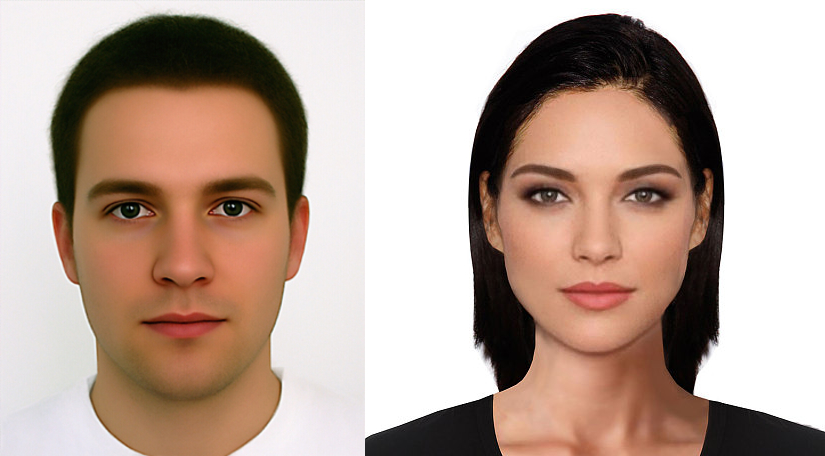

In [2]:
image = array(Image.open('test_gabung.jpg'))
image_sobel = image.copy()
Image.fromarray(image)

In [3]:
image_new = image.copy()
for idx_row, row in enumerate(image):
    for idx_col, column in enumerate(row):
        image_new[idx_row][idx_col][0] = 0.299 * image[idx_row][idx_col][0] + 0.587 * image[idx_row][idx_col][1] + 0.114 * image[idx_row][idx_col][2]
        image_new[idx_row][idx_col][1] = 128 - 0.169 * image[idx_row][idx_col][0] - 0.331 * image[idx_row][idx_col][1] + 0.5 * image[idx_row][idx_col][2]
        image_new[idx_row][idx_col][2] = 128 + 0.5 * image[idx_row][idx_col][0] - 0.419 * image[idx_row][idx_col][1] - 0.081 * image[idx_row][idx_col][2]

In [4]:
# ( Y > 50)and (Y < 175) and
#  ( Cb > 90)and (Cb < 120) and ……….. (4)
#  ( Cr > 140)and (Cr < 165) and
#  ( Cr > 𝐶b)and (Cr − Cb > 15)
def isSkinColor(pixel):
    return pixel[0] > 80 and pixel[1] > 85 and pixel[1] < 135 and pixel[2] > 135 and pixel[2] < 180
#     return pixel[0] > 50 and pixel[0] < 175 and pixel[1] > 90 and pixel[1] < 120 and pixel[2] > 140 and pixel[2] < 165 and pixel[2] > pixel[1] and pixel[2] - pixel[1] > 15

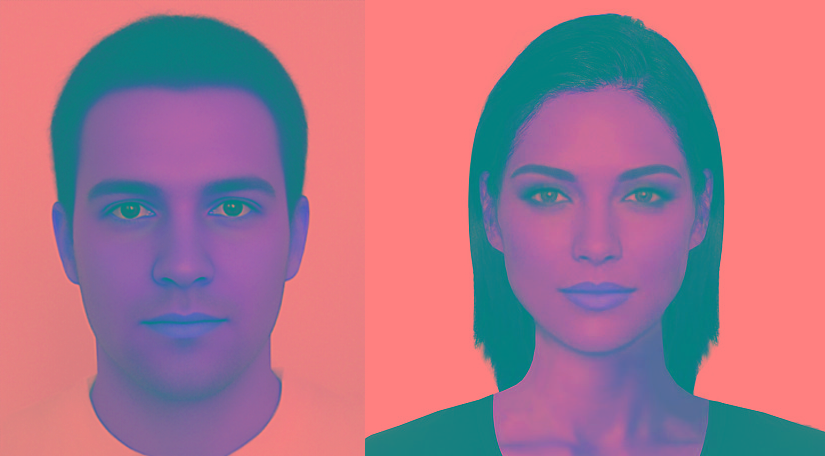

In [5]:
Image.fromarray(image_new)

In [6]:
image_face = image_new.copy()

In [7]:
for idx_row, row in enumerate(image_face):
    for idx_col, col in enumerate(row):
        if isSkinColor(col):
            image_face[idx_row][idx_col] = 255
        else:
            image_face[idx_row][idx_col] = 0

In [8]:
skin_map_result = Image.fromarray(image_face).convert('L')

In [9]:
skin_map_arr = array(skin_map_result)

In [10]:
skin_map_arr.shape

(456, 825)

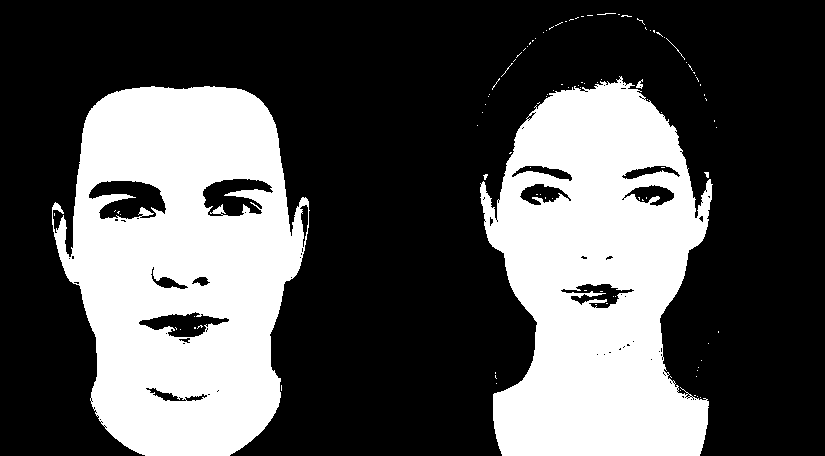

In [11]:
Image.fromarray(skin_map_arr)

In [12]:
def flood_fill(image_arr, row_start, col_start, source_color, target_color):
    Q = queue.Queue()
    Q.put((row_start, col_start))
    min_x = 9999
    min_y = 9999
    max_x = -9999
    max_y = -9999
    while (not(Q.empty())):
        (row_start, col_start) = Q.get()
        if (row_start >= 0 and row_start < image_arr.shape[0] and col_start >= 0 and col_start < image_arr.shape[1]):
            if (image_arr[row_start][col_start] == source_color): 
                if (row_start < min_y):
                    min_y = row_start
                if (row_start > max_y):
                    max_y = row_start
                if (col_start < min_x):
                    min_x = col_start
                if (col_start > max_x):
                    max_x = col_start
            
                image_arr[row_start][col_start] = target_color
                Q.put((row_start + 1, col_start))
                Q.put((row_start - 1, col_start))
                Q.put((row_start, col_start + 1))
                Q.put((row_start, col_start - 1))
                Q.put((row_start - 1, col_start - 1))
                Q.put((row_start - 1, col_start + 1))
                Q.put((row_start + 1, col_start - 1))
                Q.put((row_start + 1, col_start + 1))
                
    return ((min_x, max_x, min_y, max_y))

In [13]:
candidate_face = []
for idx_row, row in enumerate(skin_map_arr):
    for idx_col, col in enumerate(row):
        if col == 255:
            min_x, max_x, min_y, max_y = flood_fill(skin_map_arr, idx_row, idx_col, 255, 0)
            candidate_face.append((min_x, max_x, min_y, max_y))

In [14]:
def filter_with_ratio(candidate_face):
    result = []
    for min_col, max_col, min_row, max_row in candidate_face:
        width = max_col - min_col
        height = max_row - min_row
        if width != 0:
            ratio = height / width
            if height >= 100:
                result.append((min_col, max_col, min_row, max_row))
    return result

In [15]:
ratio_filter_result = filter_with_ratio(candidate_face)

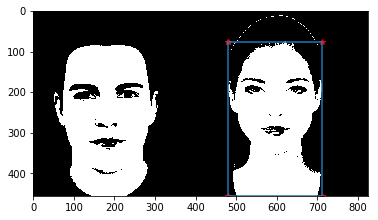

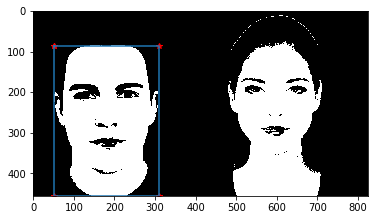

In [16]:
for min_col, max_col, min_row, max_row in ratio_filter_result:
    x = [min_col, max_col, max_col, min_col, min_col]
    y = [min_row, min_row, max_row, max_row, min_row]
    imshow(image_face)
    plot(x, y, 'r*')
    plot(x, y)
    show()

# Everything Starts Here

In [17]:
def use_sobel(img, width, height):
    newimg = Image.new("RGB", (width, height), "white")
    for x in range(1, width-1):  # ignore the edge pixels for simplicity (1 to width-1)
        for y in range(1, height-1): # ignore edge pixels for simplicity (1 to height-1)

            # initialise Gx to 0 and Gy to 0 for every pixel
            Gx = 0
            Gy = 0

            # top left pixel
            p = img.getpixel((x-1, y-1))
            r = p[0]
            g = p[1]
            b = p[2]

            # intensity ranges from 0 to 765 (255 * 3)
            intensity = r + g + b

            # accumulate the value into Gx, and Gy
            Gx += -intensity
            Gy += -intensity

            # remaining left column
            p = img.getpixel((x-1, y))
            r = p[0]
            g = p[1]
            b = p[2]

            Gx += -2 * (r + g + b)

            p = img.getpixel((x-1, y+1))
            r = p[0]
            g = p[1]
            b = p[2]

            Gx += -(r + g + b)
            Gy += (r + g + b)

            # middle pixels
            p = img.getpixel((x, y-1))
            r = p[0]
            g = p[1]
            b = p[2]

            Gy += -2 * (r + g + b)

            p = img.getpixel((x, y+1))
            r = p[0]
            g = p[1]
            b = p[2]

            Gy += 2 * (r + g + b)

            # right column
            p = img.getpixel((x+1, y-1))
            r = p[0]
            g = p[1]
            b = p[2]

            Gx += (r + g + b)
            Gy += -(r + g + b)

            p = img.getpixel((x+1, y))
            r = p[0]
            g = p[1]
            b = p[2]

            Gx += 2 * (r + g + b)

            p = img.getpixel((x+1, y+1))
            r = p[0]
            g = p[1]
            b = p[2]

            Gx += (r + g + b)
            Gy += (r + g + b)

            # calculate the length of the gradient (Pythagorean theorem)
            length = math.sqrt((Gx * Gx) + (Gy * Gy))

            # normalise the length of gradient to the range 0 to 255
            length = length / 4328 * 255

            length = int(length)

            # draw the length in the edge image
            #newpixel = img.putpixel((length,length,length))
            newimg.putpixel((x,y),(length,length,length))
    return newimg

In [18]:
sobel_image = use_sobel(Image.fromarray(image_sobel), image_sobel.shape[1], image_sobel.shape[0])

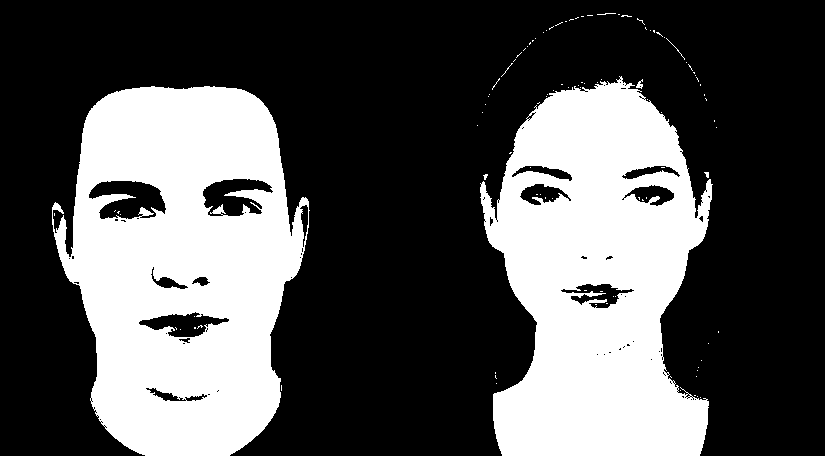

In [19]:
Image.fromarray(image_face)

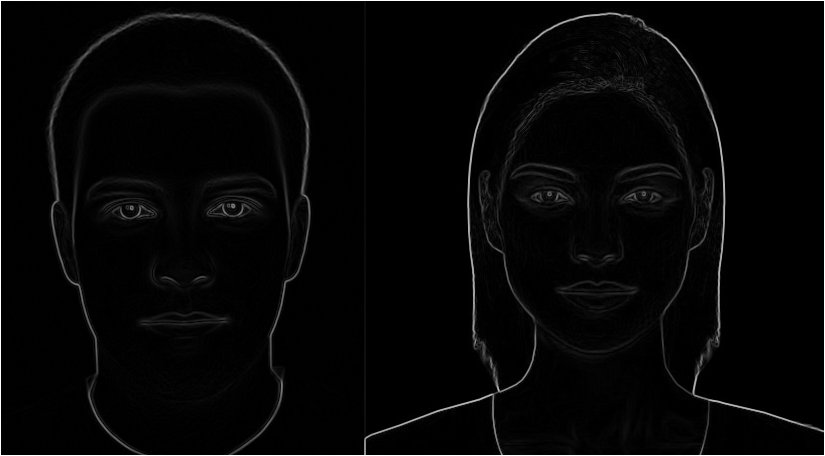

In [20]:
sobel_image

In [21]:
sobel_image_arr = array(sobel_image)

# Morphological

In [22]:
def image_dilation(image_arr):
    # the structuring element is a 5 pixel x 5 pixel square
    height = image_arr.shape[0]
    widht = image_arr.shape[1]
    new_image = image_arr.copy()
    for pixel_y in range(height):
        for pixel_x in range(widht):
            roi = image_arr[max(0, pixel_y - 2): min(height, pixel_y + 3),
                                    max(0, pixel_x - 2): min(widht, pixel_x + 3)]
            new_image[pixel_y][pixel_x] = np.amax(roi)
    return new_image

In [23]:
def image_erosion(image_arr):
    # the structuring element is a 5 pixel x 5 pixel square
    height = image_arr.shape[0]
    widht = image_arr.shape[1]
    new_image = image_arr.copy()
    for pixel_y in range(height):
        for pixel_x in range(widht):
            roi = image_arr[max(0, pixel_y - 2): min(height, pixel_y + 3),
                                    max(0, pixel_x - 2): min(widht, pixel_x + 3)]
            new_image[pixel_y][pixel_x] = np.amin(roi)
    return new_image

In [24]:
def image_closing(image_arr):
    dilated = image_dilation(image_arr)
    eroded = image_erosion(dilated)
    return eroded

In [25]:
def image_opening(image_arr):
    eroded = image_erosion(image_arr)
    dilated = image_dilation(eroded)
    return dilated

In [26]:
def get_valid_index(image_arr, row, column):
    if row < 0 or column < 0:
        return 0
    elif row >= image_arr.shape[0]:
        return image_arr.shape[0] - 1
    elif column >= image_arr.shape[1]:
        return image_arr.shape[1] - 1
    else:
        return image_arr[row][column]

In [27]:
def image_dilation_disk(image_arr):
    # the structuring element is a 3 pixel x 3 pixel disk
    height = image_arr.shape[0] - 1
    widht = image_arr.shape[1] - 1
    new_image = image_arr.copy()
    for pixel_y in range(height):
        for pixel_x in range(widht):
            roi1 = image_arr[min(height, pixel_y + 3)][pixel_x]
            roi2 = image_arr[min(height, pixel_y + 2)][max(0, pixel_x - 2): min(pixel_x + 3, widht)]
            roi3 = image_arr[min(height, pixel_y + 1)][max(0, pixel_x - 2): min(pixel_x + 3, widht)]
            roi4 = image_arr[pixel_y][max(0, pixel_x - 3): min(pixel_x + 4, widht)]
            roi5 = image_arr[max(0, pixel_y - 1)][max(0, pixel_x - 2): min(pixel_x + 3, widht)]
            roi6 = image_arr[max(0, pixel_y - 2)][max(0, pixel_x - 2): min(pixel_x + 3, widht)]
            roi7 = image_arr[max(0, pixel_y - 3)][pixel_x]
            amax1 = np.amax(roi1)
            amax2 = np.amax(roi2)
            amax3 = np.amax(roi3)
            amax4 = np.amax(roi4)
            amax5 = np.amax(roi5)
            amax6 = np.amax(roi6)
            amax7 = np.amax(roi7)
            roi = np.array([amax1, amax2, amax3, amax4, amax5, amax6, amax7])
            new_image[pixel_y][pixel_x] = np.amax(roi)
    return new_image

In [28]:
def image_erosion_disk(image_arr):
    # the structuring element is a 3 pixel x 3 pixel disk
    height = image_arr.shape[0]
    widht = image_arr.shape[1]
    new_image = image_arr.copy()
    for pixel_y in range(height):
        for pixel_x in range(widht):
            roi1 = image_arr[min(height - 1, pixel_y + 3)][pixel_x]
            roi2 = image_arr[min(height - 1, pixel_y + 2)][max(0, pixel_x - 2): min(pixel_x + 3, widht)]
            roi3 = image_arr[min(height - 1, pixel_y + 1)][max(0, pixel_x - 2): min(pixel_x + 3, widht)]
            roi4 = image_arr[pixel_y][max(0, pixel_x - 3): min(pixel_x + 4, widht)]
            roi5 = image_arr[max(0, pixel_y - 1)][max(0, pixel_x - 2): min(pixel_x + 3, widht)]
            roi6 = image_arr[max(0, pixel_y - 2)][max(0, pixel_x - 2): min(pixel_x + 3, widht)]
            roi7 = image_arr[max(0, pixel_y - 3)][pixel_x]
            amax1 = np.amin(roi1)
            amax2 = np.amin(roi2)
            amax3 = np.amin(roi3)
            amax4 = np.amin(roi4)
            amax5 = np.amin(roi5)
            amax6 = np.amin(roi6)
            amax7 = np.amin(roi7)
            roi = np.array([amax1, amax2, amax3, amax4, amax5, amax6, amax7])
            new_image[pixel_y][pixel_x] = np.amin(roi)
    return new_image

# Cleaning Image

In [29]:
def flood_fill_clean(image_arr, row_start, col_start):
    Q = queue.Queue()
    Q.put((row_start, col_start))
    while (not(Q.empty())):
        (row_start, col_start) = Q.get()
        if (row_start >= 0 and row_start < image_arr.shape[0] and col_start >= 0 and col_start < image_arr.shape[1]):
            if (image_arr[row_start][col_start] == 0):    
                image_arr[row_start][col_start] = 255
                Q.put((row_start + 1, col_start))
                Q.put((row_start - 1, col_start))
                Q.put((row_start, col_start + 1))
                Q.put((row_start, col_start - 1))
                Q.put((row_start - 1, col_start - 1))
                Q.put((row_start - 1, col_start + 1))
                Q.put((row_start + 1, col_start - 1))
                Q.put((row_start + 1, col_start + 1))

In [30]:
def clean_image(image_arr):
    height = image_arr.shape[0]
    widht = image_arr.shape[1]
    for i in range(height):
        flood_fill_clean(image_arr, i, 0)
        flood_fill_clean(image_arr, i, widht - 1)

In [31]:
def flood_fill_count_area(image_arr, row_start, col_start):
    Q = queue.Queue()
    Q.put((row_start, col_start))
    result = 0
    start_row = row_start
    start_col = col_start
    while (not(Q.empty())):
        (row_start, col_start) = Q.get()
        if (row_start >= 0 and row_start < image_arr.shape[0] and col_start >= 0 and col_start < image_arr.shape[1]):
            if (image_arr[row_start][col_start] == 0):    
                result += 1
                image_arr[row_start][col_start] = 255
                Q.put((row_start + 1, col_start))
                Q.put((row_start - 1, col_start))
                Q.put((row_start, col_start + 1))
                Q.put((row_start, col_start - 1))
                Q.put((row_start - 1, col_start - 1))
                Q.put((row_start - 1, col_start + 1))
                Q.put((row_start + 1, col_start - 1))
                Q.put((row_start + 1, col_start + 1))
                
    return ((start_row, start_col, result))

# Find Face Part

In [32]:
def find_eye_center(start_index_row, image_arr):
    width = image_arr.shape[1]
    height = image_arr.shape[0] // 2
    for idx_row in range(start_index_row, height):
        found_black = False
        found_white = False
        found_first = None
        found_second = None
        for idx_col in range(width):
            if image_arr[idx_row][idx_col] == 0:
                if found_black:
                    if found_white:
                        if idx_col - found_first[1] >= width // 5:
                            found_second = (idx_row, idx_col)
                else:
                    found_black = True
                    found_first = (idx_row, idx_col)
            elif found_black:
                if (image_arr[idx_row][idx_col] == 255):
                    found_white = True
        if found_second:
            return (found_first, found_second)

In [33]:
def find_mouth(image_arr, result_area):
    width = image_arr.shape[1]
    height = image_arr.shape[0]
    for idx_row in range(height // 2, height):
        for idx_col in range(width):
            if image_arr[idx_row][idx_col] == 0:
                if (flood_fill_count_area(image_arr, idx_row, idx_col)[2] >= width // 5):
                    return (idx_row, idx_col)

# Control Point

In [34]:
def find_point(image_arr, min_row, max_row, min_col, max_col, threshold):
    result = []
    # Find From Left
    for idx_row in range(min_row, max_row):
        for idx_col in range(min_col, max_col):
            if image_arr[idx_row][idx_col] >= threshold:
                result.append((idx_row, idx_col))
                break
    
    # Find From Right
    for idx_row in range(min_row, max_row):
        for idx_col in range(max_col, min_col, -1):
            if image_arr[idx_row][idx_col] >= threshold:
                result.append((idx_row, idx_col))
                break
    
    # Find From Top
    for idx_col in range(min_col, max_col):
        for idx_row in range(min_row, max_row):
            if image_arr[idx_row][idx_col] >= threshold:
                result.append((idx_row, idx_col))
                break
                
    # Find From Bottom
    for idx_col in range(min_col, max_col):
        for idx_row in range(max_row, min_row, -1):
            if image_arr[idx_row][idx_col] >= threshold:
                result.append((idx_row, idx_col))
                break
    
    
    return result

In [35]:
def find_control_point(point_list, num_of_control_point):
    result = []
    
    total_num = len(point_list)
    increment = total_num // num_of_control_point
    if total_num == 0:
        return result
    else:
        for i in range(0, total_num, increment):
            result.append(point_list[i])
        return result

# Main Program

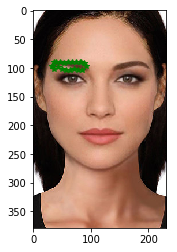

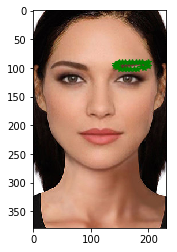

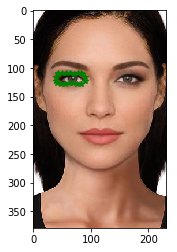

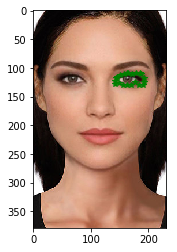

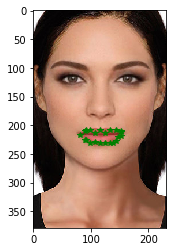

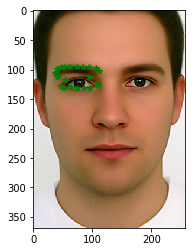

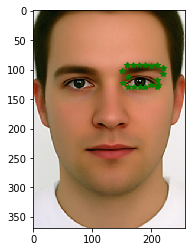

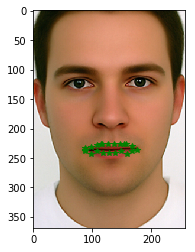

In [44]:
for min_col, max_col, min_row, max_row in ratio_filter_result:
    x = [min_col, max_col, max_col, min_col, min_col]
    y = [min_row, min_row, max_row, max_row, min_row]
    image_face_grayscale = Image.fromarray(image_face).crop((min_col, min_row, max_col, max_row)).convert('L')
    
    image_face_rgb = Image.fromarray(image).crop((min_col, min_row, max_col, max_row))
    image_arr = array(image_face_grayscale)
    
    # Dilation The Image
    dilation_image = image_dilation(image_arr)
#     imshow(Image.fromarray(dilation_image))
    
    # Clean The Image
    clean_image(dilation_image)
#     imshow(Image.fromarray(dilation_image))
    
    # Find Area
    image_copy = dilation_image.copy()
    result_area = []
    for idx_row, row in enumerate(image_copy):
        for idx_col, col in enumerate(row):
            if col == 0:
                result_area.append(flood_fill_count_area(image_copy, idx_row, idx_col))
    
    # Delete Area Below 10
    for idx_row, idx_col, area in result_area:
        if area < 10:
            flood_fill_count_area(dilation_image, idx_row, idx_col)
    
    
    # Find Eye
    eyelash_center = find_eye_center(0, dilation_image)
    eye_center = find_eye_center(eyelash_center[0][0] + dilation_image.shape[0] // 20, dilation_image)
    
    # Find Mouth
    copy_image_dilation = dilation_image.copy() # copy for not deleting
    mouth_center = find_mouth(copy_image_dilation, result_area)
    
    # Add Boundary
    result = image_arr.copy()
    boundary = []
    boundary.append(flood_fill(image_arr, eyelash_center[0][0], eyelash_center[0][1], 0, 255))
    boundary.append(flood_fill(image_arr, eyelash_center[1][0], eyelash_center[1][1], 0, 255))
    boundary.append(flood_fill(image_arr, eye_center[0][0], eye_center[0][1], 0, 255))
    boundary.append(flood_fill(image_arr, eye_center[1][0], eye_center[1][1], 0, 255))
    boundary.append(flood_fill(image_arr, mouth_center[0], mouth_center[1], 0, 255))

    # Sobel
    image_sobel = Image.fromarray(sobel_image_arr).crop((min_col, min_row, max_col, max_row)).convert('L')
    image_sobel_arr = array(image_sobel)
    
    # Use Boundary to Add Point
    for min_col, max_col, min_row, max_row in boundary:
        if min_col == 9999:
            continue
        x = [min_col, max_col, max_col, min_col, min_col]
        y = [min_row, min_row, max_row, max_row, min_row]
        
        result = find_point(image_sobel_arr, min_row, max_row, min_col, max_col, 10)
        result = find_control_point(result, 20)
    
        for x1, y1 in result:
            plot(y1, x1, 'g*')
        imshow(image_face_rgb)
#         plot(x, y, 'r*')
#         plot(x, y)
    
        show()
    
    